In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
import konlpy
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

okt = Okt()


In [2]:
train_data = pd.read_table('train_data.txt')
test_data = pd.read_table('test_data.txt')

print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력
print('테스트 리뷰 개수 :',len(test_data)) # 훈련용 리뷰 개수 출력
train_data[:5] # 상위 5개 출력
# label : 긍정(0), 부정(1)
sample_txt = "추어탕 진짜 맛있게 잘 하는 집입니다 완전 강추!"
print(okt.morphs(sample_txt, stem = True))
print(okt.pos(sample_txt))



훈련용 리뷰 개수 : 20861
테스트 리뷰 개수 : 4000
['추어탕', '진짜', '맛있다', '자다', '하다', '집', '이다', '완전', '강추', '!']
[('추어탕', 'Noun'), ('진짜', 'Noun'), ('맛있게', 'Adjective'), ('잘', 'Verb'), ('하는', 'Verb'), ('집', 'Noun'), ('입니다', 'Adjective'), ('완전', 'Noun'), ('강추', 'Noun'), ('!', 'Punctuation')]


In [3]:
train_data['document'].nunique(), train_data['label'].nunique()
train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(train_data))


총 샘플의 수 : 20861


   label  count
0    0.0  10502
1    1.0  10359


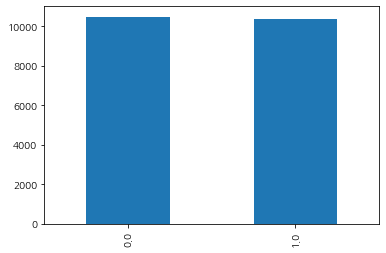

In [4]:
# 긍정,부정 분포도
train_data['label'].value_counts().plot(kind = 'bar')
print(train_data.groupby('label').size().reset_index(name = 'count'))


In [5]:
#리뷰 중 null값 있는지 확인
print(train_data.isnull().values.any()) # Null값 제거 전
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False
False


In [6]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]


,# id,point,document,label
0,1103557752,5.0,갓김치에 같이먹으니 너무너므 맛있고 직원들이 착하고 친절해서 기분좋게 먹고나왔습니...,0.0
1,1103557752,5.0,리뷰보고 갔는데 푸짐하고 맛나요 담에 여수 가면 또 가도 될듯요 예약하고 가니 ...,0.0
2,1103557752,5.0,정말 맛있어요 최고,0.0
3,1103557752,5.0,너무 맛있게 잘먹었어요 사장님도 넘 친절하세요,0.0
4,1103557752,5.0,너무 너무 맛있어요친절하시고요 짱짱,0.0


In [7]:
# white space 데이터를 empty value로 변경 
train_data['document'] = train_data['document'].str.replace('^ +', "") 
train_data['document'].replace('', np.nan, inplace=True)
train_data = train_data.dropna(how='any') # Null 값 제거

print(train_data.isnull().sum())


# id        0
point       0
document    0
label       0
dtype: int64


In [8]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))


전처리 후 테스트용 샘플의 개수 : 3999


In [9]:
## TOKENIZER
#불용어
list_file = [line.rstrip('\n') for line in open('result.txt', 'r')]
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
#불용어에 음식 이름 추가
stopwords = stopwords + list_file;
print(stopwords[100:102])
okt.morphs('감자튀김 맛집이에요 서비스도 많이 주시고 맛있는 식사 잘먹고 갑니다', stem = True)

['국', '국물']


['감자',
 '튀김',
 '맛집',
 '이에요',
 '서비스',
 '도',
 '많이',
 '주시',
 '고',
 '맛있다',
 '식사',
 '잘',
 '먹다',
 '가다']

In [10]:
X_train = []
for sentence in train_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)


In [11]:
stopwords.append("보쌈")
X_test = []
for sentence in test_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)
    
print(X_test[:3])

[['기가맥힌', '맛집', '맛깔나다'], ['너무', '맛있다'], ['여기', '진짜', '최고', '맛있다']]


In [12]:
# Make Vocaburary
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_test) # 훈련데이터셋 사용
print(tokenizer.word_index)

{'먹다': 1, '맛있다': 2, '맛': 3, '너무': 4, '좋다': 5, '없다': 6, '가다': 7, '이다': 8, '을': 9, '있다': 10, '나오다': 11, '안': 12, '보다': 13, '않다': 14, '요': 15, '오다': 16, '음식': 17, '같다': 18, '다': 19, '고': 20, '직원': 21, '진짜': 22, '만': 23, '분': 24, '친절하다': 25, '로': 26, '맛집': 27, '에서': 28, '아니다': 29, '하고': 30, '정말': 31, '곳': 32, '많다': 33, '방문': 34, '별로': 35, '그냥': 36, '되다': 37, '들다': 38, '주문': 39, '시키다': 40, '그렇다': 41, '가격': 42, '서비스': 43, '반찬': 44, '리뷰': 45, '주다': 46, '못': 47, '때': 48, '님': 49, '자다': 50, '받다': 51, '인': 52, '손님': 53, '짜다': 54, '것': 55, '그': 56, '사장': 57, '갈치': 58, '서': 59, '더': 60, '기분': 61, '또': 62, '사람': 63, '말': 64, '다른': 65, '두': 66, '넘다': 67, '분위기': 68, '테이블': 69, '양념': 70, '처음': 71, '추천': 72, '정도': 73, '집': 74, '인데': 75, '시간': 76, '뷰': 77, '많이': 78, '나': 79, '수': 80, 'ㅎㅎ': 81, '돈': 82, '비싸다': 83, '까지': 84, '갈다': 85, '여기': 86, '모르다': 87, '싶다': 88, '게': 89, '조림': 90, '생각': 91, '분들': 92, '해주다': 93, 'ㅠㅠ': 94, '보고': 95, '이라': 96, '제': 97, '여행': 98, '나다': 99, '중': 100, '아깝다': 101, '기다리다': 102

In [13]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 7162
등장 빈도가 2번 이하인 희귀 단어의 수: 4192
단어 집합에서 희귀 단어의 비율: 58.53113655403519
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.399970979042723


In [14]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 2971


In [15]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
print(X_train[:3])


[[639, 183, 1, 3, 513, 2, 20, 753, 19, 52, 5, 1, 13, 222, 92, 441, 31, 6, 1458, 786, 8, 49, 54, 13, 462, 108, 57], [96, 145, 6, 164, 261, 31, 4, 86, 21, 445, 331, 48, 1160, 39, 199, 21, 99, 31, 6, 786, 1459, 21, 877], [30, 2, 126]]


In [16]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [17]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))


20844
20844


/Users/esens/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


리뷰의 최대 길이 : 108
리뷰의 평균 길이 : 21.18129917482249


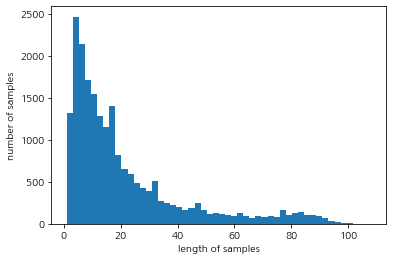

In [18]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [19]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [20]:
max_len = 40
below_threshold_len(max_len, X_train)

X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 85.21397044713108


In [21]:
#LSTM
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [22]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [23]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)


In [24]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
278/278 [==============================] - 13s 40ms/step - loss: 0.2064 - acc: 0.9141 - val_loss: 0.2487 - val_acc: 0.9091

Epoch 00001: val_acc improved from -inf to 0.90909, saving model to best_model.h5
Epoch 2/15
278/278 [==============================] - 13s 46ms/step - loss: 0.1014 - acc: 0.9645 - val_loss: 0.2010 - val_acc: 0.9307

Epoch 00002: val_acc improved from 0.90909 to 0.93068, saving model to best_model.h5
Epoch 3/15
278/278 [==============================] - 15s 54ms/step - loss: 0.0881 - acc: 0.9691 - val_loss: 0.1311 - val_acc: 0.9501

Epoch 00003: val_acc improved from 0.93068 to 0.95011, saving model to best_model.h5
Epoch 4/15
278/278 [==============================] - 15s 55ms/step - loss: 0.0802 - acc: 0.9724 - val_loss: 0.1741 - val_acc: 0.9297

Epoch 00004: val_acc did not improve from 0.95011
Epoch 5/15
278/278 [==============================] - 15s 55ms/step - loss: 0.0762 - acc: 0.9736 - val_loss: 0.2028 - val_acc: 0.9304

Epoch 00005: val_acc di

In [25]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

125/125 [==============================] - 3s 15ms/step - loss: 0.2173 - acc: 0.9280

 테스트 정확도: 0.9280


In [26]:
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score < 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))
    

In [27]:
sentiment_predict('분위기갑. 파스타존맛.재방문각.')

sentiment_predict('비빔은 진짜 강추! 물냉면은 쏘쏘!')

sentiment_predict('머리털 나고 리뷰 처음 남겨봅니다. 거두절미하고 비싸고 양 적고 서비스 최악의 식당을 느껴보고 싶으신 분들께 추천합니다. 그러나 맛과 서비스 등 제값 하는 식당을 원하는 분들께는 비추천합니다.')

sentiment_predict('단아하고좋았어요 근데.. 점심시간이라그런지 코스요리인데도 너무빨리나오고 음식을 빨리먹어야되고.. 음식도 그닥')

sentiment_predict('존맛탱ㅠ 넘 친절하세요 굿굿!!')

1.71% 확률로 긍정 리뷰입니다.

20.32% 확률로 부정 리뷰입니다.

0.06% 확률로 부정 리뷰입니다.

12.09% 확률로 부정 리뷰입니다.

0.07% 확률로 긍정 리뷰입니다.

